In [8]:
%matplotlib notebook
%matplotlib inline

## Retail Sales ETL Pipeline

W tym notebooku krok po kroku pokazuję:
- jak wyglądały dane przed czyszczeniem
- jak zostały przeze mnie oczyszczone i połączone
- jakie funkcjonalności utworzyłem po przygotowaniu danych
- jak wyglądają wizualizację w dwóch wersjach: technicznej i biznesowej

## Krok 1: Czyszczenie danych (ETL - Extract & Clean)

Na tym etapie dane pobierane są z lokalnej bazy danych SQL Server.
Skrypt clear.py odpowiada za przygotowanie danych do dalszej analizy.

### Wykonywane operacje
- **Pobranie danych** z bazy do tabel Pandas DataFrame
- **Uzupełnienie braków**:
  - brakujące wartości w kolumnie 'City' zastąpione wartością 'Nieznane'
  - brakujące daty rejestracji 'RegistrationDate' zastąpione datą bieżącą
- **Usunięcie duplikatów**
- **Konwersja typów danych**
  - 'SaleDate' i 'RegistrationDate', przekonwertowane do formatu daty ('datetime')
- **Walidacja dat**
  - wykrywanie niepoprawnych dat
  - sprawdzanie i oznaczanie dat rejestracji znajdujących się w przyszłości
- **Zapis wyników**
  - oczyszczone dane są zapisywane do plików CSV w katalogu 'data/processed'
 
**Dzięki temu etapowi dalsze kroki analizy wykonywane są już na poprawnych i spójnych danych**

In [5]:
import os
os.chdir("C:/Users/przem/PycharmProjects/RetailSalesEtl")
print("Now working in:", os.getcwd())

Now working in: C:\Users\przem\PycharmProjects\RetailSalesEtl


## Krok 2: Łączenie danych

Na tym etapie łączone są wszystkie wcześniej oczyszczone tabele (`sales`, `customers`, `products`) w jedną wspólną tabelę **main**, która posłuży jako baza do dalszych analiz.

### Wykonywane operacje:
- Wczytanie plików CSV z oczyszczonymi danymi (`sales.csv`, `customers.csv`, `products.csv`).
- Połączenie danych:
  - `sales` + `customers` → po kluczu **CustomerID** (LEFT JOIN),
  - wynik + `products` → po kluczu **ProductID** (LEFT JOIN).
- Rezultat to zintegrowany zbiór danych, zawierający zarówno transakcje, jak i szczegóły klientów oraz produktów.
- Zapis pełnej tabeli do pliku `data/processed/main.csv`.

Dzięki temu etapowi mamy jedną spójną tabelę, która jest podstawą do tworzenia nowych cech (feature engineering) oraz analiz biznesowych.


In [2]:
import pandas as pd
from IPython.display import display

# wczytanie danych
df_sales = pd.read_csv("../data/processed/sales.csv")
df_customers = pd.read_csv("../data/processed/customers.csv")
df_products = pd.read_csv("../data/processed/products.csv")

# łączenie (LEFT JOIN)
df_main = df_sales.merge(df_customers, on="CustomerID", how="left")
df_main = df_main.merge(df_products, on="ProductID", how="left")

# podgląd wyników
print("Rozmiar tabeli głównej:", df_main.shape)
display(df_main.head())

Rozmiar tabeli głównej: (1000, 12)


,SaleID,CustomerID,ProductID,Quantity,SaleDate,FirstName,LastName,RegistrationDate,City,ProductName,Category,UnitPrice
0,1,44,7,3,2024-07-03,456D5,7D83D21,2023-02-24,Gdańsk,Czekolada mleczna,Spożywcze,6.99
1,2,31,2,1,2024-08-23,F4F13,AC07F62,2023-09-12,Nieznane,Smartphone Max,Elektronika,3199.99
2,3,27,7,4,2024-07-27,A7FBC,F6F286C,2023-03-28,Kraków,Czekolada mleczna,Spożywcze,6.99
3,4,35,6,1,2025-06-17,83C92,C3081A0,2023-06-23,Gdańsk,Zegarek sportowy,Elektronika,899.99
4,5,15,5,4,2024-09-10,02741,E178374,2024-10-30,Nieznane,Kurtka zimowa,Odzież,699.99


## Krok 3: Dodanie kolumn pomocniczych

Do mojej tabeli dodałem kilka kolumn pomocniczych, takich jak YearMonth (dzień i miesiąc z SaleDate), DayName (nazwa dnia tygodnia) i kilka innych.

### Wykonywane operacje:
- Dodanie kolumn pomocniczych oraz zapis zmienionej tabeli do pliku CSV.

In [3]:
# konwersja SaleDate na datetime
df_main['SaleDate'] = pd.to_datetime(df_main['SaleDate'])

df_main['YearMonth'] = df_main['SaleDate'].dt.to_period('M')
df_main['DayName'] = df_main['SaleDate'].dt.day_name()
df_main['Quarter'] = 'Q' + df_main['SaleDate'].dt.quarter.astype(str)
df_main['TotalValue'] = df_main['UnitPrice'] * df_main['Quantity']

display(df_main.head())

,SaleID,CustomerID,ProductID,Quantity,SaleDate,FirstName,LastName,RegistrationDate,City,ProductName,Category,UnitPrice,YearMonth,DayName,Quarter,TotalValue
0,1,44,7,3,2024-07-03,456D5,7D83D21,2023-02-24,Gdańsk,Czekolada mleczna,Spożywcze,6.99,2024-07,Wednesday,Q3,20.97
1,2,31,2,1,2024-08-23,F4F13,AC07F62,2023-09-12,Nieznane,Smartphone Max,Elektronika,3199.99,2024-08,Friday,Q3,3199.99
2,3,27,7,4,2024-07-27,A7FBC,F6F286C,2023-03-28,Kraków,Czekolada mleczna,Spożywcze,6.99,2024-07,Saturday,Q3,27.96
3,4,35,6,1,2025-06-17,83C92,C3081A0,2023-06-23,Gdańsk,Zegarek sportowy,Elektronika,899.99,2025-06,Tuesday,Q2,899.99
4,5,15,5,4,2024-09-10,02741,E178374,2024-10-30,Nieznane,Kurtka zimowa,Odzież,699.99,2024-09,Tuesday,Q3,2799.96


## Krok 4: Tworzenie wizualizacji

Na podstawie przygotowanych danych dodałem do raportu kilka wykresów różnego typu: słupkowy, liniowy oraz kartogram,
aby zaprezentować kilka możliwości biblioteki Matplotlib.

### Wykonywane operacje:
- **Utworzenie wykresu liniowego** przedstawiającego trend łącznej wartości sprzedaży produktów na przestrzeni roku w poszczególnych miesiącach
- **Utworzenie wykresu słupkowego** przedstawiającego sumę wartości sprzedaży produktów w poszczególnych kwartałach
- **Utworzenie wykresu słupkowego** przedstawiającego sumę wartości sprzedaży produktów w poszczególnych dniach tygodnia
- **Utworzenie wykresu słupkowego** z legendą przedstawiającego sumę wartości sprzedaży poszczególnych produktów
- **Utworzenie mapy ciepła (heatmapy)** przedstawiającej wartość sprzedaży danego produktu w zależności od kwartału

Najpierw dodałem odpowiednie importy i utworzyłem konfigurację: podział wykresów na wersję techniczną oraz biznesową.
Utworzyłem także funkcje pomocnicze przy rysowaniu kolejnych wykresów.

In [4]:
import sys
import matplotlib.pyplot as plt
import mplcursors
import matplotlib.ticker as mtick
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import numpy as nmp

# --- Configuration ---
MODE = "technical"
if len(sys.argv) > 1:
    MODE = sys.argv[1].lower()
    if MODE not in ["technical", "business"]:
        MODE = "technical"

# --- Helper functions ---
def format_axis_as_millions(ax):
    ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x/1e6:.1f} mln'))

def add_interactive_cursor(ax):
    cursor = mplcursors.cursor(ax, hover=True)
    @cursor.connect("add")
    def on_add(sel):
        sel.annotation.set_text(f"{sel.target[1]:,.2f} zł")
        sel.annotation.get_bbox_patch().set(fc="white", alpha=0.8)

def finalize_plot(ax, xlabel=None, ylabel=None, title=None, rotate_xticks=None):
    if xlabel: plt.xlabel(xlabel)
    if ylabel: plt.ylabel(ylabel)
    if title: plt.title(title, fontsize=14)
    if rotate_xticks:
        plt.xticks(rotation=rotate_xticks, ha='right', fontsize=8)
    plt.tight_layout()
    plt.show()

def add_hover_highlight(fig, bars, highlight_color="gold", fade_alpha=0.6):
    def on_hover(event):
            for bar in bars:
                if bar.contains(event)[0]:
                    bar.set_alpha(1.0)
                    bar.set_edgecolor(highlight_color)
                    bar.set_linewidth(2)
                else:
                    bar.set_alpha(fade_alpha)
                    bar.set_edgecolor("black")
                    bar.set_linewidth(1)
            fig.canvas.draw_idle()

    fig.canvas.mpl_connect("motion_notify_event", on_hover)

**Wykres liniowy** przedstawiający trend łącznej wartości sprzedaży produktów na przestrzeni roku w poszczególnych miesiącach

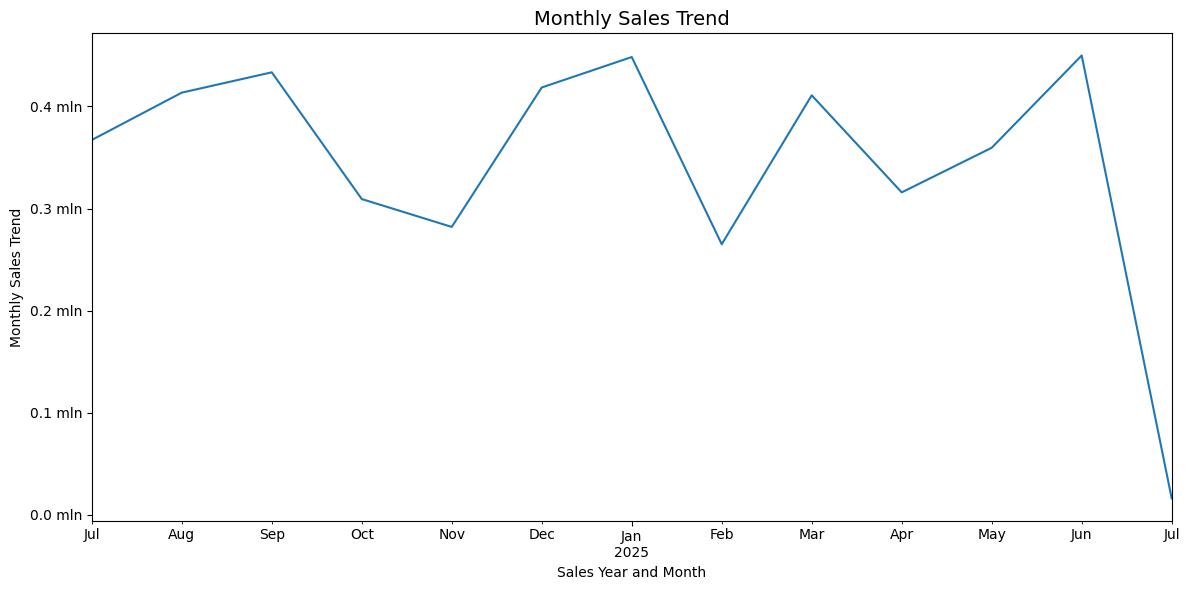

In [17]:
def draw_monthly_sales(df):
    monthly_sales = df.groupby(df['SaleDate'].dt.to_period('M'))['TotalValue'].sum()
    
    if MODE == "business":
        ax = monthly_sales.plot(kind='line', figsize=(12,6), color="royalblue", linewidth=2.5, marker="o")
    else:
        ax = monthly_sales.plot(kind='line', figsize=(12,6))

    format_axis_as_millions(ax)
    finalize_plot(ax, xlabel='Sales Year and Month', ylabel='Monthly Sales Trend',
                  title='Monthly Sales Trend')

draw_monthly_sales(df_main)

**Wykres słupkowy** przedstawiający sumę wartości sprzedaży produktów w poszczególnych kwartałach

**Wnioski**:
- sprzedaż jest porównywalna niezależnie od kwartału, co wskazuje na brak silnej sezonowości sprzedaży
- Q3 ma najwyższą wartość sprzedaży, co sugeruje okres największej aktywności sprzedażowej
- Q1 i Q2 mają bardzo zbliżone wartości, co może sugerować względną stabilność sprzedaży w pierwszej połowie roku
- **policz odchylenie standardowe i wyciągnij wnioski**

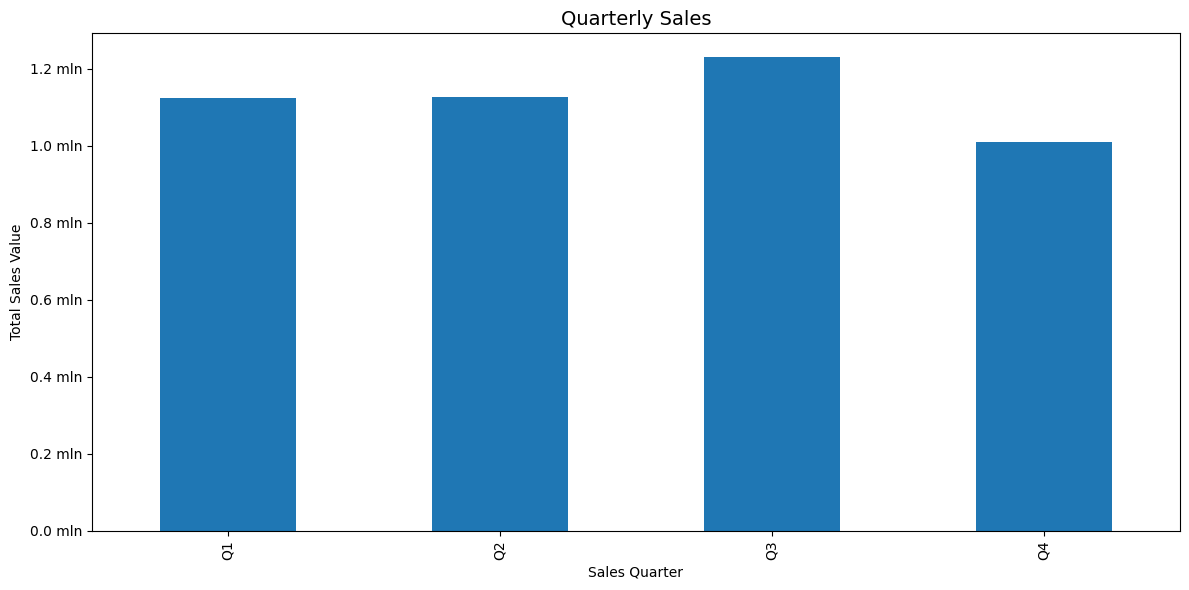

In [20]:
def draw_quarter_sales(df):
    quarter_sales = df.groupby('Quarter')['TotalValue'].sum()
    
    if MODE == "business":
        fig, ax = plt.subplots(figsize=(12,6))
        cmap = mcolors.LinearSegmentedColormap.from_list("", ["seagreen", "lightgreen"])
        colors = [cmap(i/len(quarter_sales)) for i in range(len(quarter_sales))]
        bars = ax.bar(quarter_sales.index, quarter_sales.values, color=colors, edgecolor="black")

        add_hover_highlight(fig, bars)
    else:
        ax = quarter_sales.plot(kind='bar', figsize=(12,6))
    
    format_axis_as_millions(ax)
    add_interactive_cursor(ax)
    finalize_plot(ax, xlabel='Sales Quarter', ylabel='Total Sales Value', title='Quarterly Sales')

draw_quarter_sales(df_main)

**Wykres słupkowy** przedstawiający sumę wartości sprzedaży produktów w poszczególnych dniach tygodnia

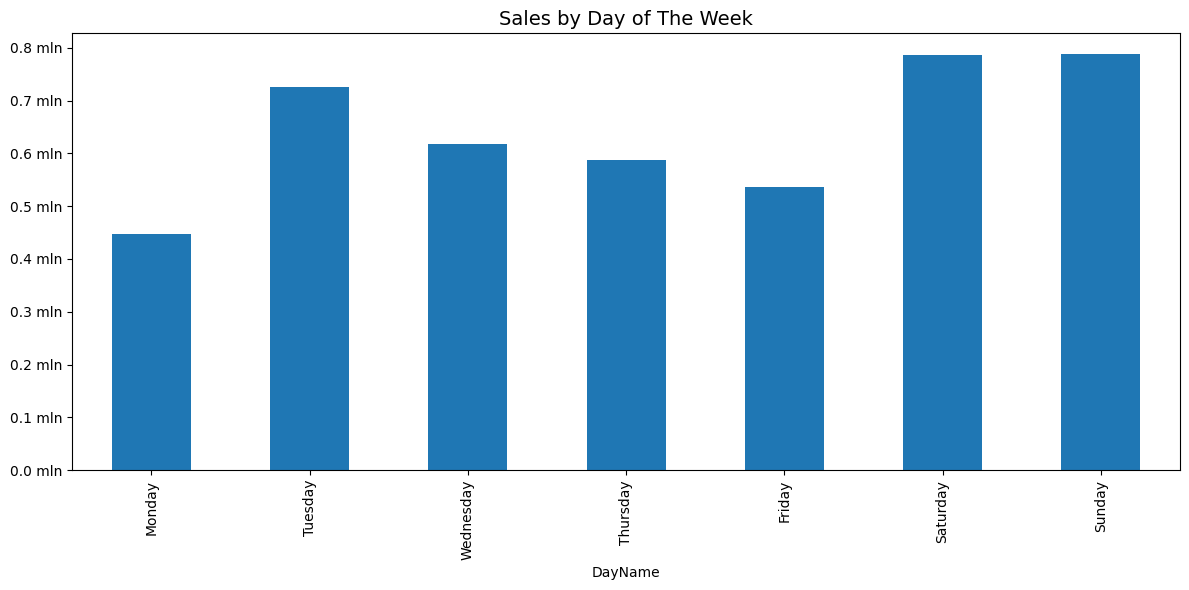

In [5]:
def draw_days_of_week_sales(df):
    day_sales = df.groupby('DayName')['TotalValue'].sum()
    day_sales = day_sales.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
    
    if MODE == "business":
        fig, ax = plt.subplots(figsize=(12,6))
        cmap = mcolors.LinearSegmentedColormap.from_list("", ["seagreen", "lightgreen"])
        colors = [cmap(i/len(day_sales)) for i in range(len(day_sales))]
        bars = ax.bar(day_sales.index, day_sales.values, color=colors, edgecolor="black")

        add_hover_highlight(fig, bars)
    else:
        ax = day_sales.plot(kind='bar', figsize=(12,6))

    format_axis_as_millions(ax)
    add_interactive_cursor(ax)
    finalize_plot(ax, title='Sales by Day of The Week')

draw_days_of_week_sales(df_main)

**Wykres słupkowy** z legendą przedstawiający sumę wartości sprzedaży poszczególnych produktów

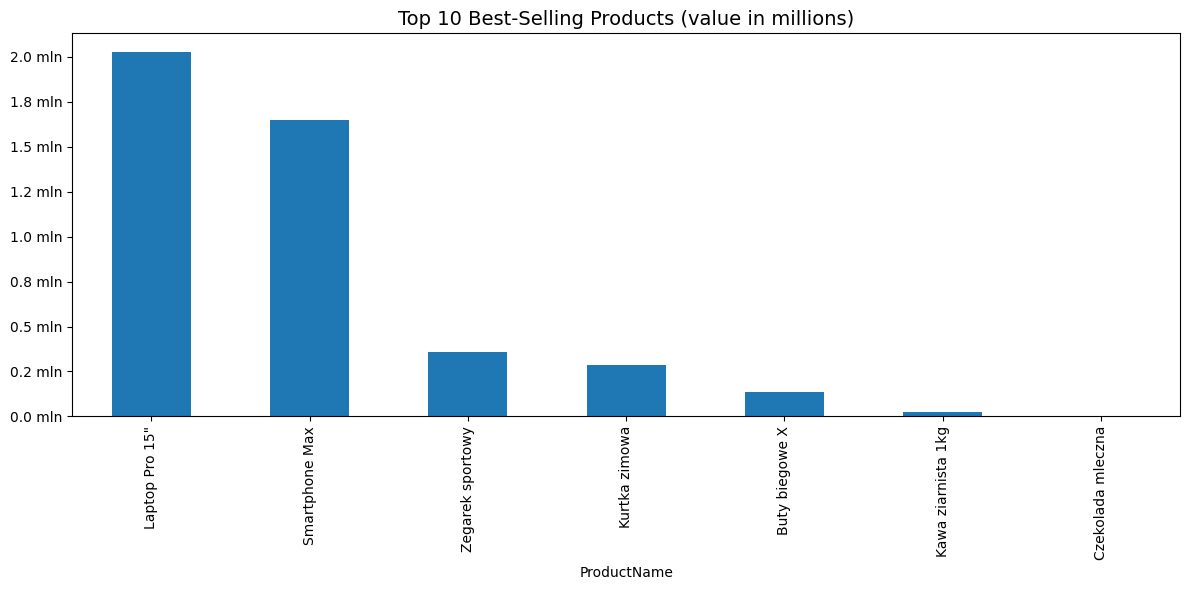

In [7]:
def draw_top_products(df):
    top_products = df.groupby('ProductName')['TotalValue'].sum().sort_values(ascending=False).head(10)

    if MODE == "technical":
        ax = top_products.plot(kind='bar', figsize=(12,6))
    else:
        colors = plt.cm.tab10(range(len(top_products)))
        ax = top_products.plot(kind='bar', figsize=(12,6), color=colors)

        handles = [
            mpatches.Patch(color=c, label=label)
            for c, label in zip(colors, top_products.index)
        ]

        ax.legend(
            handles=handles,
            title="Products",
            bbox_to_anchor=(1.02, 1),
            loc="upper left",
            borderaxespad=0.0
        )

        ax.set_xticklabels([])
        plt.tight_layout(rect=[0, 0, 0.8, 1])

    format_axis_as_millions(ax)
    add_interactive_cursor(ax)
    finalize_plot(ax, title='Top 10 Best-Selling Products (value in millions)', xlabel='')

draw_top_products(df_main)

**Mapa ciepła (heatmapa)** przedstawiająca wartość sprzedaży danego produktu w zależności od kwartału

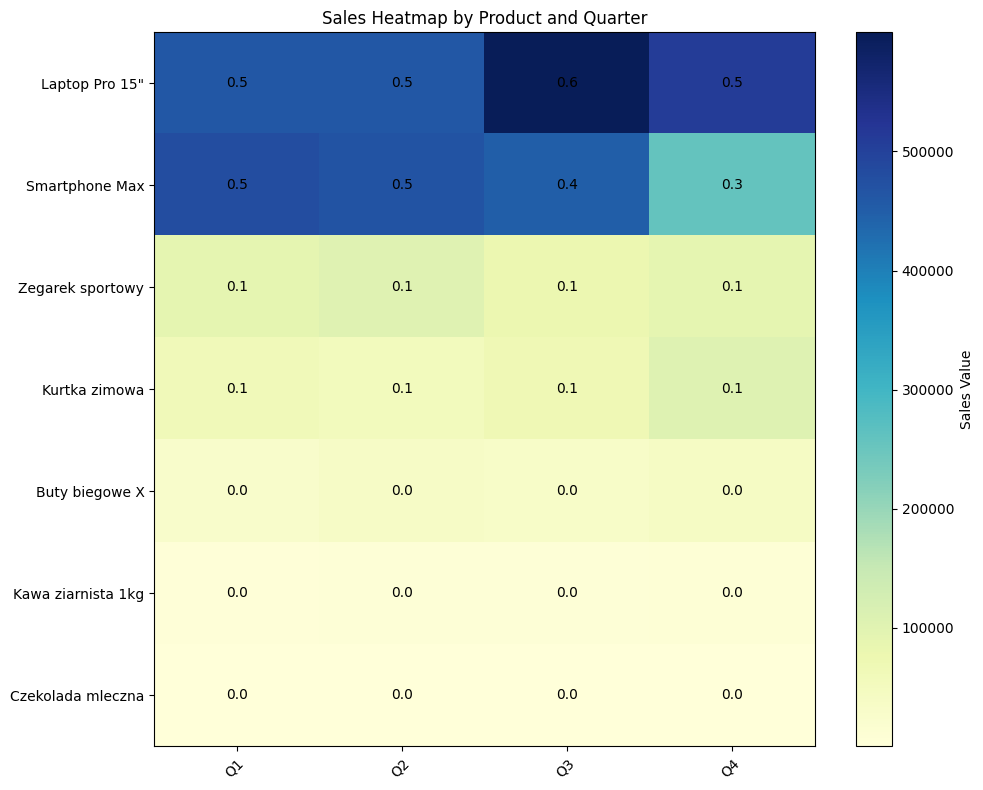

In [9]:
def draw_product_quarter_heatmap(df):
    pivot = df.pivot_table(
        index="ProductName",
        columns="Quarter",
        values="TotalValue",
        aggfunc="sum"
    ).fillna(0)

    pivot = pivot.loc[pivot.sum(axis=1).sort_values(ascending=False).index]
    fig, ax = plt.subplots(figsize=(10,8))

    cax = ax.imshow(pivot.values, cmap="YlGnBu", aspect="auto")

    ax.set_xticks(nmp.arange(len(pivot.columns)))
    ax.set_yticks(nmp.arange(len(pivot.index)))
    ax.set_xticklabels(pivot.columns)
    ax.set_yticklabels(pivot.index)

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    for i in range(len(pivot.index)):
        for j in range(len(pivot.columns)):
            value = pivot.values[i,j]
            ax.text(j, i, f"{value/1e6:.1f}", ha="center", va="center", color="black")

    fig.colorbar(cax, ax=ax, label="Sales Value")

    ax.set_title("Sales Heatmap by Product and Quarter")
    fig.tight_layout()
    plt.show()

draw_product_quarter_heatmap(df_main)